In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#загружаем данные
df = pd.read_csv('new_dataframe.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head(5)

,user_id,hour,os,order_class,surge,app_opened,price_seen,order_made,ride_completed,user_cancelled,city_center_order,distance,age,rfm
0,867689,12,iOS,business,no surge,1,1,1,1,0,0,7.982135,20,low
1,752172,5,Android,economy,no surge,1,1,1,1,0,1,2.908468,27,high
2,486559,15,Android,comfort,no surge,1,1,1,1,0,0,7.224614,21,high
3,304024,0,Android,economy,no surge,1,1,1,1,0,1,1.874349,52,low
4,139420,0,Android,business,no surge,1,1,1,1,0,0,10.704778,19,low


### НАБЛЮДЕНИЕ_1: 
В период Surge видим более низкую price-to-order конверсию

### ГИПОТЕЗА_1: 
Если убрать надпись "повышенный спрос" то конверсия в заказ в период сурджа увеличится на 10пп.

In [3]:
#выбираем пользователей, которые делали заказ в период сурджа
df_surge = df.query("surge == 'surge'")
len(df_surge)

31643

In [6]:
#находим конверсию в заказ
df_surge['price_to_order_conv'] = round(df_surge.order_made / df_surge.price_seen,2) * 100

#находим среднюю конверсию относительно юзера (чтобы не было повторных вхождений юзера в выборки)
df_surge_by_user = df_surge.groupby('user_id', as_index=False).agg({'price_to_order_conv': 'mean'})

#распределяем пользователей на тестовую и контрольные группы
df_surge_by_user['group'] = np.random.randint(2, size=len(df_surge_by_user['price_to_order_conv'])) #колонка с рандом знач
df_surge_by_user.group.value_counts() #кол-во пользователей в каждой из групп


C:\Users\sanch\AppData\Local\Temp/ipykernel_924/190599459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_surge['price_to_order_conv'] = round(df_surge.order_made / df_surge.price_seen,2) * 100


0    8904
1    8876
Name: group, dtype: int64

In [7]:
#разбили датафрейм по группам 0-контрольная, 1-тестовая
group_0 = df_surge_by_user.query("group == 0")
group_1 = df_surge_by_user.query("group == 1")

In [8]:
print('кол-во наблюдений в group_0 =', len(group_0))
print('кол-во наблюдений в group_1 =', len(group_1))
print('общее кол-во наблюдений =', len(group_1) + len(group_0)) #проверка что никто не потерялся
print('средняя поюзерная конверсия (контрольная группа) =', round(group_0.price_to_order_conv.mean(),2))

print('средняя поюзерная конверсия (тестовая группа) =', round(group_1.price_to_order_conv.mean(),2))

кол-во наблюдений в group_0 = 8904
кол-во наблюдений в group_1 = 8876
общее кол-во наблюдений = 17780
средняя поюзерная конверсия (контрольная группа) = 72.26
средняя поюзерная конверсия (тестовая группа) = 72.44


#### УСЛОВИЯ при проведении t-теста для проверки стат значимости равенства средних

H_0: средние конверсии в 2х группах одинаковые

H_1: средние конверсии в 2х группах различны

p-value > alpha: принимаем H_0

p-value < alpha: отклоняем H_0

In [9]:
#t-тест средних конверсий
alpha = 0.05
ttest_ind(group_0['price_to_order_conv'], group_1['price_to_order_conv'])
t = ttest_ind(group_0['price_to_order_conv'], group_1['price_to_order_conv'])

if t.pvalue > alpha:
    print(f'p-value {round(t.pvalue, 2)} > alpha {round(alpha, 2)}\nПринимаем H_0 - средние выборок равны.\nГруппы равномерные и их можно использовать для дальнейшего a/b теста ')
else:
    print(f'p-value {round(t.pvalue, 2)} < alpha {round(alpha, 2)}\nОтклоняем H_0 - средние выборок не равны\nГруппы не равномерные. Необходимо пересмотреть разделение на группы')

p-value 0.76 > alpha 0.05
Принимаем H_0 - средние выборок равны.
Группы равномерные и их можно использовать для дальнейшего a/b теста 


### Проведем bootstrap для сравнения средних

(array([ 2.,  5.,  6., 11., 22., 21., 14., 10.,  8.,  1.]),
 array([-1.36631062, -1.06284567, -0.75938072, -0.45591577, -0.15245081,
         0.15101414,  0.45447909,  0.75794404,  1.061409  ,  1.36487395,
         1.6683389 ]),
 <BarContainer object of 10 artists>)

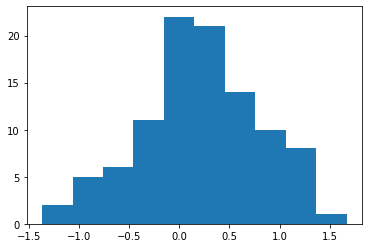

In [10]:
p_diffs = []
for i in range(100):
    sample_new_mean = group_1.sample(frac=1, replace=True)['price_to_order_conv'].mean()
    sample_old_mean = group_0.sample(frac=1, replace=True)['price_to_order_conv'].mean()
    p_diffs.append(sample_new_mean - sample_old_mean)
plt.hist(p_diffs)

In [13]:
#переводим list p_diffs в df
p_diffs=pd.DataFrame(p_diffs)
p_diffs.columns=['mean_of_metric']

alpha = 0.05 #уровень значимости (вероятность ошибочно отклонить H_0)
A = round(p_diffs['mean_of_metric'].quantile(alpha/2),3) #левая граница
B = round(p_diffs['mean_of_metric'].quantile(1-alpha/2),3) #правая граница

if A < 0 < B:
    print(f'"0" находится внутри интервала [{A} ; {B}]. \nПринимаем H_0 - средние выборок равны.\nГруппы равномерные и их можно использовать для дальнейшего a/b теста')
else:
    print(f'0 находится за границей интервала [{A} ; {B}]. \nОтвергаем H_0 - средние выборок неравны.\nГруппы не равномерные. Необходимо пересмотреть разделение на группы')

"0" находится внутри интервала [-0.932 ; 1.155]. 
Принимаем H_0 - средние выборок равны.
Группы равномерные и их можно использовать для дальнейшего a/b теста


### НАБЛЮДЕНИЕ_2: 
Если заказ Comfort & Business класса, то более низкие юзерские отмены, более длинные поездки

### ГИПОТЕЗА: 
Если понизить стоимость поездки на бизнес класс на 5%, то средняя дистанция уменьшится (т.е. пользователи будут чаще выбирать бизнес и на более короткие поездки)

In [14]:
#длина поездки в разбивке по классам
df.groupby('order_class',as_index=False).agg({'distance':'mean'})

,order_class,distance
0,business,12.013842
1,comfort,5.025267
2,economy,3.997445


In [15]:
#выбираем заказы класса business
df_business = df.query("order_class == 'business' and order_made == 1")

In [16]:
#находим средюю дистанцию для каждого юзера
df_business = df_business.groupby('user_id', as_index=False) \
                        .agg({'distance': 'mean'}) \
                        .rename(columns={'distance':'distance_mean'}) \
                        .fillna(0) #заполнили нулями пустые ячейки в distance 
                                   #по идее их не должно быть если user_canceled == 0 )
                
#распределяем пользователей по 2м группам для теста
df_business['group'] = np.random.randint(2, size=len(df_business['distance_mean'])) #колонка с рандом знач
df_business.group.value_counts()
df_business.head()

,user_id,distance_mean,group
0,100134,13.714453,1
1,100424,22.763366,1
2,100463,9.949819,1
3,100643,12.505037,1
4,100675,13.270409,0


In [17]:
#разделяем пользователей на группы
group_business_0 = df_business.query("group == 0")
group_business_1 = df_business.query("group == 1")

print('кол-во наблюдений в group_business_0 =', len(group_business_0))
print('кол-во наблюдений в group_business_1 =', len(group_business_1))
print('средняя поюзерная дистанция (контрольная группа) =', round(group_business_0.distance_mean.mean(),2))

print('средняя поюзерная дистанция (тестовая группа) =', round(group_business_1.distance_mean.mean(),2))

кол-во наблюдений в group_business_0 = 3624
кол-во наблюдений в group_business_1 = 3687
средняя поюзерная дистанция (контрольная группа) = 12.07
средняя поюзерная дистанция (тестовая группа) = 12.06


In [19]:
#t-тест средних конверсий
alpha = 0.05
ttest_ind(group_business_0['distance_mean'], group_business_1['distance_mean'])

t = ttest_ind(group_business_0['distance_mean'], group_business_1['distance_mean'])
if t.pvalue > alpha:
    print(f'p-value {round(t.pvalue, 2)} > alpha {round(alpha, 2)}\nПринимаем H_0 - средние выборок равны.\nГруппы равномерные и их можно использовать для дальнейшего a/b теста ')
else:
    print(f'p-value {round(t.pvalue, 2)} < alpha {round(alpha, 2)}\nОтклоняем H_0 - средние выборок не равны\nГруппы не равномерные. Необходимо пересмотреть разделение на группы')

p-value 0.9 > alpha 0.05
Принимаем H_0 - средние выборок равны.
Группы равномерные и их можно использовать для дальнейшего a/b теста 


### Проведем бутстрап для сравнения средних

(array([ 3.,  7., 10., 20., 13., 22., 14.,  4.,  5.,  2.]),
 array([-0.24594765, -0.19760251, -0.14925737, -0.10091223, -0.05256709,
        -0.00422195,  0.04412318,  0.09246832,  0.14081346,  0.1891586 ,
         0.23750374]),
 <BarContainer object of 10 artists>)

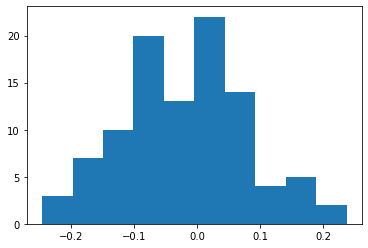

In [20]:
p_diffs = []
for i in range(100):
    sample_new_mean = group_business_1.sample(frac=1, replace=True)['distance_mean'].mean()
    sample_old_mean = group_business_0.sample(frac=1, replace=True)['distance_mean'].mean()
    p_diffs.append(sample_new_mean - sample_old_mean)
plt.hist(p_diffs)

In [21]:
p_diffs=pd.DataFrame(p_diffs)
p_diffs.columns=['mean_of_metric']

alpha = 0.05 #уровень значимости (вероятность ошибочно отклонить H_0)
A = round(p_diffs['mean_of_metric'].quantile(alpha/2),3) #левая граница
B = round(p_diffs['mean_of_metric'].quantile(1-alpha/2),3) #правая граница

if A < 0 < B:
    print(f'"0" находится внутри интервала [{A} ; {B}]. \nПринимаем H_0 - средние выборок равны.\nГруппы равномерные и их можно использовать для дальнейшего a/b теста')
else:
    print(f'0 находится за границей интервала [{A} ; {B}]. \nОтвергаем H_0 - средние выборок неравны.\nГруппы не равномерные. Необходимо пересмотреть разделение на группы')

"0" находится внутри интервала [-0.194 ; 0.177]. 
Принимаем H_0 - средние выборок равны.
Группы равномерные и их можно использовать для дальнейшего a/b теста


In [23]:
df_2 = pd.read_csv('post_abtest_data.csv')
df_2

,user_id,date,app_opened,group,price_seen,order_made,surge,os,user_cancelled,city_center_order,groups
0,867689,2020-05-28,1,Control,1,1,no surge,Android,0.0,1.0,Control
1,867689,2020-05-29,1,Control,1,0,surge,iOS,NaN,NaN,Control
2,867689,2020-05-25,1,Control,1,1,surge,Android,0.0,0.0,Control
3,752172,2020-05-29,1,Control,1,1,surge,Android,0.0,1.0,Control
4,752172,2020-05-28,1,Control,1,1,no surge,iOS,0.0,0.0,Control
...,...,...,...,...,...,...,...,...,...,...,...
101495,777065,2020-05-25,1,Control,1,0,no surge,Android,NaN,NaN,Control
101496,340213,2020-05-28,1,Control,1,1,no surge,iOS,0.0,1.0,Control
101497,352605,2020-05-26,1,Test,1,1,no surge,Android,0.0,1.0,Test
101498,216082,2020-05-26,1,Control,1,0,surge,Android,NaN,NaN,Control


In [25]:
df

,user_id,hour,os,order_class,surge,app_opened,price_seen,order_made,ride_completed,user_cancelled,city_center_order,distance,age,rfm
0,867689,12,iOS,business,no surge,1,1,1,1,0,0,7.982135,20,low
1,752172,5,Android,economy,no surge,1,1,1,1,0,1,2.908468,27,high
2,486559,15,Android,comfort,no surge,1,1,1,1,0,0,7.224614,21,high
3,304024,0,Android,economy,no surge,1,1,1,1,0,1,1.874349,52,low
4,139420,0,Android,business,no surge,1,1,1,1,0,0,10.704778,19,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101495,288445,16,Android,comfort,no surge,1,1,1,1,0,0,1.725907,28,high
101496,627754,2,iOS,comfort,surge,1,1,1,1,0,1,6.206134,23,low
101497,784442,1,iOS,economy,no surge,1,1,1,1,0,0,6.624225,21,high
101498,232993,13,iOS,business,no surge,1,1,1,1,0,0,8.825188,26,high
